# Sentimen Analisis Pada Teks Review Movie IMDB
#### by Ahmad Yamin

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

## Import data & Eksplorasi Data

In [3]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [11]:
movie_reviews.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [4]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

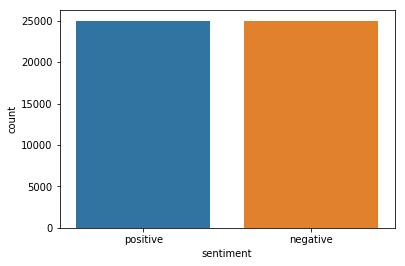

In [10]:
import seaborn as sns


sns.countplot(x='sentiment', data=movie_reviews)

In [12]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

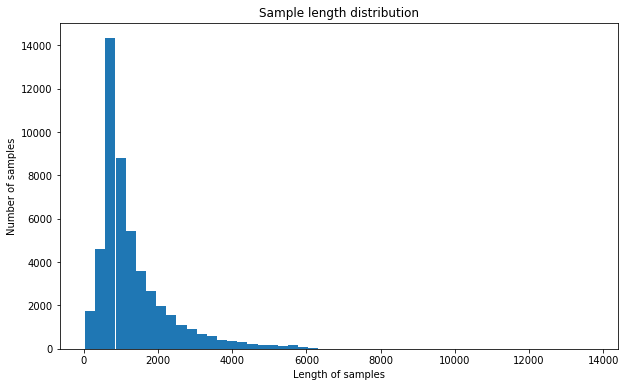

In [15]:
# Now, let's see the average number of words per sample
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(movie_reviews['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

## Data Preprocessing

In [16]:

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [17]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [18]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [19]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [21]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

## Pemisahan Data Test dan Train

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Menyiapkan Embedding Layer

In [23]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [26]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [27]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Membuat Model

### Model Simple Neural Network

In [57]:
#Text Classification with Simple Neural Network
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [59]:
#Train model
history = model.fit(X_train, y_train, batch_size=128, epochs=9, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 5s 155us/step - loss: 0.6053 - acc: 0.6686 - val_loss: 0.5310 - val_acc: 0.7400
Epoch 2/9
32000/32000 [==============================] - 3s 82us/step - loss: 0.4943 - acc: 0.7644 - val_loss: 0.5249 - val_acc: 0.7388
Epoch 3/9
32000/32000 [==============================] - 3s 81us/step - loss: 0.4558 - acc: 0.7897 - val_loss: 0.5173 - val_acc: 0.7488
Epoch 4/9
32000/32000 [==============================] - 3s 82us/step - loss: 0.4360 - acc: 0.7999 - val_loss: 0.5203 - val_acc: 0.7466
Epoch 5/9
32000/32000 [==============================] - 3s 83us/step - loss: 0.4170 - acc: 0.8118 - val_loss: 0.5305 - val_acc: 0.7445
Epoch 6/9
32000/32000 [==============================] - 3s 82us/step - loss: 0.4099 - acc: 0.8147 - val_loss: 0.5297 - val_acc: 0.7484
Epoch 7/9
32000/32000 [==============================] - 3s 82us/step - loss: 0.3978 - acc: 0.8205 - val_loss: 0.5527 - val_acc: 0.731

In [60]:
score = model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 1s 89us/step


In [61]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5612594516277313
Test Accuracy: 0.7358


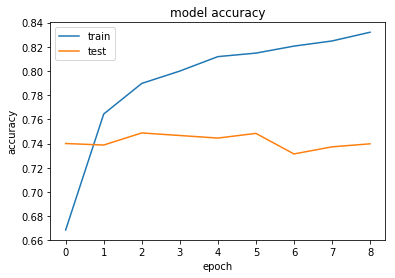

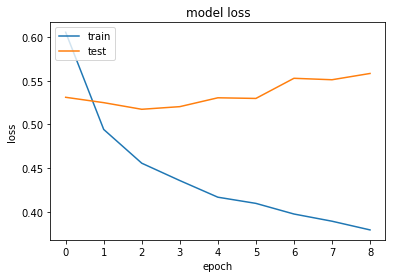

In [62]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

### Model Convolutional Neural Network

In [51]:
#Text Classification with a Convolutional Neural Network
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)


model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [52]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 9,254,801
Trainable params: 101
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [53]:
history = model.fit(X_train, y_train, batch_size=128, epochs=9, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 4s 125us/step - loss: 0.7027 - acc: 0.5110 - val_loss: 0.6858 - val_acc: 0.5414
Epoch 2/9
32000/32000 [==============================] - 3s 81us/step - loss: 0.6767 - acc: 0.5752 - val_loss: 0.6647 - val_acc: 0.6006
Epoch 3/9
32000/32000 [==============================] - 3s 81us/step - loss: 0.6611 - acc: 0.6088 - val_loss: 0.6548 - val_acc: 0.6132
Epoch 4/9
32000/32000 [==============================] - 3s 82us/step - loss: 0.6496 - acc: 0.6280 - val_loss: 0.6417 - val_acc: 0.6329
Epoch 5/9
32000/32000 [==============================] - 3s 82us/step - loss: 0.6422 - acc: 0.6363 - val_loss: 0.6344 - val_acc: 0.6468
Epoch 6/9
32000/32000 [==============================] - 3s 82us/step - loss: 0.6356 - acc: 0.6437 - val_loss: 0.6284 - val_acc: 0.6501
Epoch 7/9
32000/32000 [==============================] - 3s 82us/step - loss: 0.6307 - acc: 0.6481 - val_loss: 0.6233 - val_acc: 0.655

In [54]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6212688671112061
Test Accuracy: 0.657


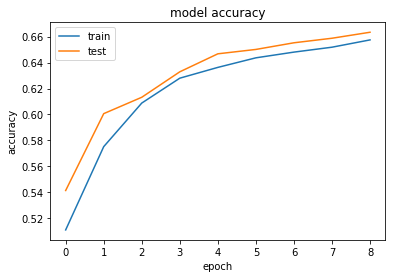

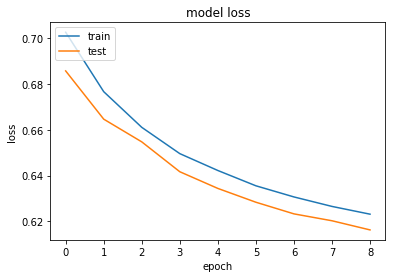

In [55]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

### Model Recurrent Neural Network (LSTM)

In [66]:
#Text Classification with Recurrent Neural Network (LSTM)
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [67]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [68]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 177s 6ms/step - loss: 0.5524 - acc: 0.7168 - val_loss: 0.4624 - val_acc: 0.7904
Epoch 2/6
32000/32000 [==============================] - 207s 6ms/step - loss: 0.4352 - acc: 0.7983 - val_loss: 0.4228 - val_acc: 0.7954
Epoch 3/6
32000/32000 [==============================] - 208s 7ms/step - loss: 0.3954 - acc: 0.8200 - val_loss: 0.3670 - val_acc: 0.8400
Epoch 4/6
32000/32000 [==============================] - 227s 7ms/step - loss: 0.3611 - acc: 0.8393 - val_loss: 0.3515 - val_acc: 0.8474
Epoch 5/6
32000/32000 [==============================] - 214s 7ms/step - loss: 0.3322 - acc: 0.8552 - val_loss: 0.3432 - val_acc: 0.8492
Epoch 6/6
10000/10000 [==============================] - 29s 3ms/step 


In [69]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33513453042507174
Test Accuracy: 0.8528


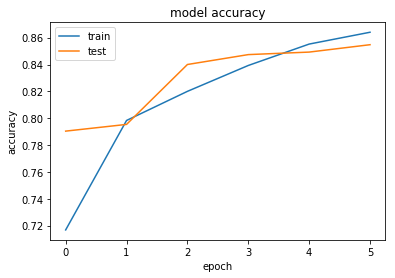

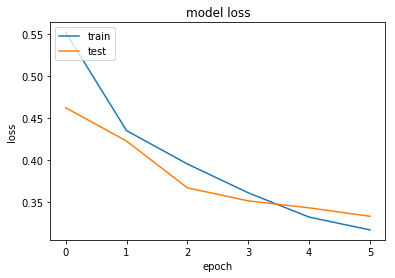

In [70]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Prediksi Pada Single Instrance

In [71]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [72]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.43665695]], dtype=float32)